# Modelo de grafos basado en modelo EpiEstim

### A. Ferragut - GACH D3

-------

In [1]:
#Paquetes
using Distributions, Plots, LaTeXStrings
default(size=(900,400))

#shifted gamma from Cori et al.
function shifted_gamma(k,a,b)
    
    res = k * cdf(Gamma(a,b),k) +  (k - 2) * cdf(Gamma(a,b),k-2) - 2 * (k - 1) * cdf(Gamma(a,b),k - 1)

    res = res + a * b * (2 * cdf(Gamma(a+1,b),k - 1) -  cdf(Gamma(a + 1, b),k - 2) - cdf(Gamma(a+1,b),k))

    return res
    
end

#Serial Interval from Cori et al.
function si_cori(mu=3.95,sigma=4.75,T=30)

    a = ((mu - 1) / sigma)^2
    b = sigma^2 / (mu - 1)

    w = shifted_gamma.((0:T),a,b)

    return w
end

##Con la geometrica para comparar
function si_geom(mean=3.95,T=30)

    p=1.0/mean
    dist=Geometric(p)
    w=pdf.(dist,(-1:T))
    return w

end;

function si_bn(mean=3.95,sigma=4.75, T=30)
    
    p = mean/sigma
    r = mean*p/(1-p)
    dist=NegativeBinomial(r,p)
    w=pdf.(dist,(-1:T-1))
    return w
end

#Fijamos la que usamos por defecto
si_distr = si_cori

si_cori (generic function with 4 methods)

### Ejemplo: shifted Gamma (Cori et. al)

Cori et al. proponen para el SI una distribución Gamma trasladada y discretizada. Tomando por ejemplo $\mu=3.95$, $\sigma = 4.75$ (valores para COVID de  [Du et al](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)) tenemos:

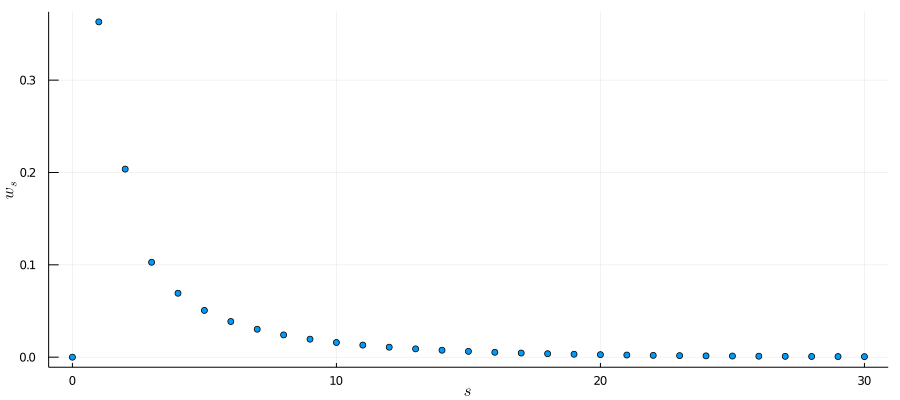

In [2]:
mu=3.95
sigma=4.75
T=30
w=si_distr(mu,sigma,T)
scatter((0:T),w,label=:none, xlabel=L"s", ylabel=L"w_s")

In [3]:
function si_distribution(k::Int64)
    
    if k in (1:30)
        return si_distr()[k+1]
    else
        return 0
    end
end
        
        

si_distribution (generic function with 1 method)

### El parámetro $R$ y la reproducción del virus.

Supongamos que una persona que se infecta el día $t$, puede generar nuevas infecciones en días subsiguientes como:

$$N_{t+s}^0 \sim Poisson(Rw_{s}),$$

independientes para cada día. Aquí $R$ es un parámetro que mide el crecimiento/decrecimiento de la epidemia, y el superíndice $0$ indica que hablamos de un infectado particular.

Se tiene que:

$$R = \sum_s R w_s = E\left[\sum_s N^0_{t+s}\right].$$

Es decir $R$ es el número medio de contagios generados por un único infectado (supuesto fijo por ahora).


### Evolución del no. de infectados

Si ahora los proceos de contagio de cada infectado son independientes, podemos sumar las v.a. Poisson de generadas por cada uno para obtener una nueva v.a. Poisson. En particular, si hay $I_0,I_1,\ldots,I_{t-1}$ infectados nuevos cada día, definimos:

$$\Lambda_t = \sum_{s<t} I_s w_{t-s}.$$

La interpretación de $\Lambda_t$ es la cantidad media de infectados que generan en $t$ los infectados previamente, si $R=1$.

La cantidad nueva de infectados en tiempo $t$ es entonces:

$$I_t \sim Poisson(R\Lambda_t)$$

ya que es la superposición de los procesos de contagio anteriores.

### DInámica de la epidemia para $R$ fijo.

Tenemos entonces completamente definida la dinámica de la epidemia, a partir de un cierto no. de infectados iniciales $I_0$. Para construir el proceso (o simularlo) debemos hacer:

> **Dinámica**
> Dados $I_0,\ldots,I_{t-1}$, construimos: $$\Lambda_t = \sum_{s<t} I_s w_{t-s}.$$
>
> Luego, sorteamos: $$I_{t+1} \sim Poisson(R\Lambda_t)$$
>
> Avanzamos $t\to t+1$ y continuamos.

Para un histórico de infectados $I_0,\ldots,I_t$ hasta tiempo $t$ y un $R$ fijo, podemos propagar la epidemia a futuro una ventana de tiempo y realizar intervalos de confianza via Monte Carlo.

In [4]:
#Funcion que ejecuta el estimador. La ventana tau es 7 por defecto.
using DSP

function epi_estim_R(incidence;window=7, si=si_distr)
    days = 1:length(incidence)
    w=si_distr();
    Lambda=filt(w,[1.0],incidence)

    a0 = 1;
    b0 = 5;

    R=zeros(size(days))
    Rl=zeros(size(days))
    Ru=zeros(size(days))

    a=zeros(size(days))
    b=zeros(size(days))
    
    for i=1:length(days)
        a[i] = a0 + filt(ones(window),[1.0],incidence[1:i])[end]
        b[i] = 1/(1/b0 + filt(ones(window),[1.0],Lambda[1:i])[end])
        R[i] = a[i]*b[i]
        
        d=Gamma(a[i],b[i])
        Rl[i] = quantile(d,0.025)
        Ru[i] = quantile(d,0.975)
    end
    return R, Rl,Ru, a, b, Lambda
end

epi_estim_R (generic function with 1 method)

In [5]:
function simula_Epiestim(R,incidence_0,dias;si=si_distr)

    pesos = si_distr()
    pesos = pesos[2:end]
    h = length(pesos)

    m=length(incidence_0)
    
    incidence=zeros(dias+m)
    Lambda = zeros(dias+m)

    incidence[1:m] = incidence_0;
    
    for i=m:dias+m-1
        Lambda[i+1] = sum(incidence[i:-1:max(i-h+1,1)].*pesos[1:min(i,h)])
        incidence[i+1] = rand(Poisson(R*Lambda[i+1]))
    end

    return incidence
end

simula_Epiestim (generic function with 1 method)

In [6]:
using LightGraphs, GraphPlot, GraphRecipes

In [30]:
#Grafo Inicial

#infectados iniciales
n0=5
g=SimpleDiGraph(n0)
t_contagio=zeros(Int64,n0)
estado = ones(Int64,n0)    #1 infectado, 2 cuarentenado
n=n0

dias=15
R=2
delay=3
K=100

T=[0]
I=[n0]
Incidence=[n0]
Q=[0]

for i=1:dias
    
    ###NUEVOS CONTAGIOS
    incidence=0
    for v in vertices(g)
        
        if estado[v]==1
            n_children = rand(Poisson(R*si_distribution(i-t_contagio[v])))
            if n_children>0
                incidence = incidence+n_children
                for j=n+1:n+n_children
                    add_vertex!(g)
                    push!(t_contagio,i)
                    push!(estado,1)
                    add_edge!(g,v,j)
                    n=n+1
                end
            end
        end
    end
    
    cupo=0
    
    ###NODOS A CUARENTENA
    for v in vertices(g)
        
        edad = i-t_contagio[v]

        if edad>delay && cupo<K
            if estado[v]==1
                estado[v]=2
                cupo=cupo+1
                for hijo in neighbors(g,v)
                    estado[v]=2
                end
            end
        end
    end

    push!(T,i)
    push!(Incidence, incidence)
    push!(I, sum(estado.==1))
    push!(Q, sum(estado.==2))

    
end



In [31]:
g

{450, 445} directed simple Int64 graph

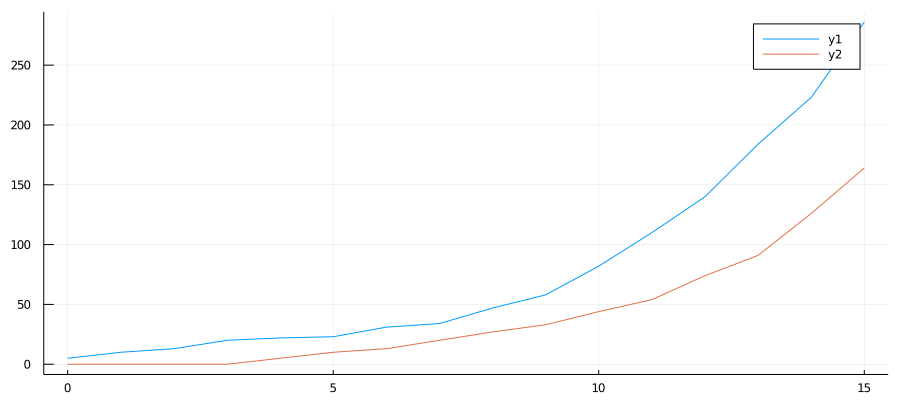

In [32]:
plot(T,I)
plot!(T,Q)

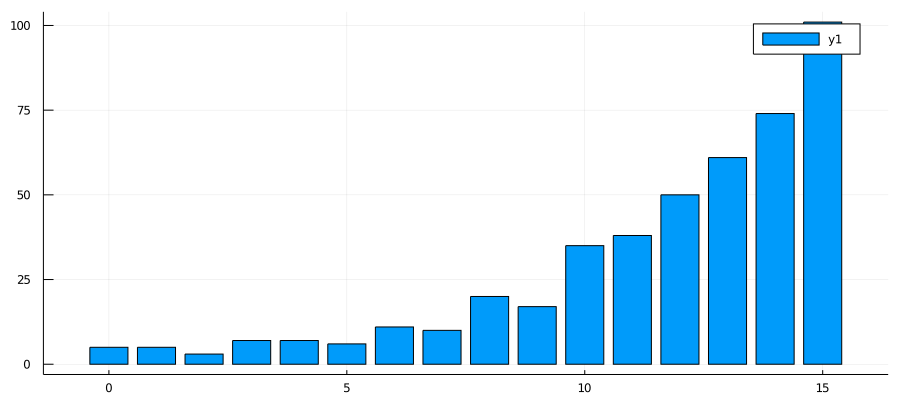

In [36]:
bar(T,Incidence)

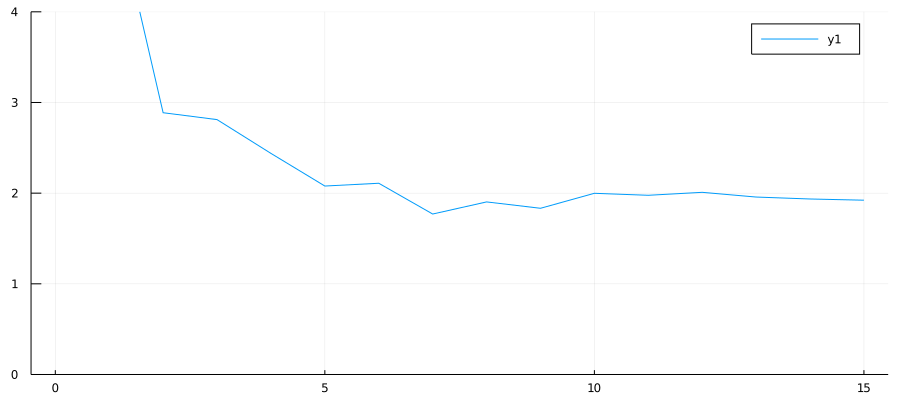

In [37]:
R,Rl,RU,a,b,Lambda = epi_estim_R(Incidence)
plot(T,R, ylim=(0,4))

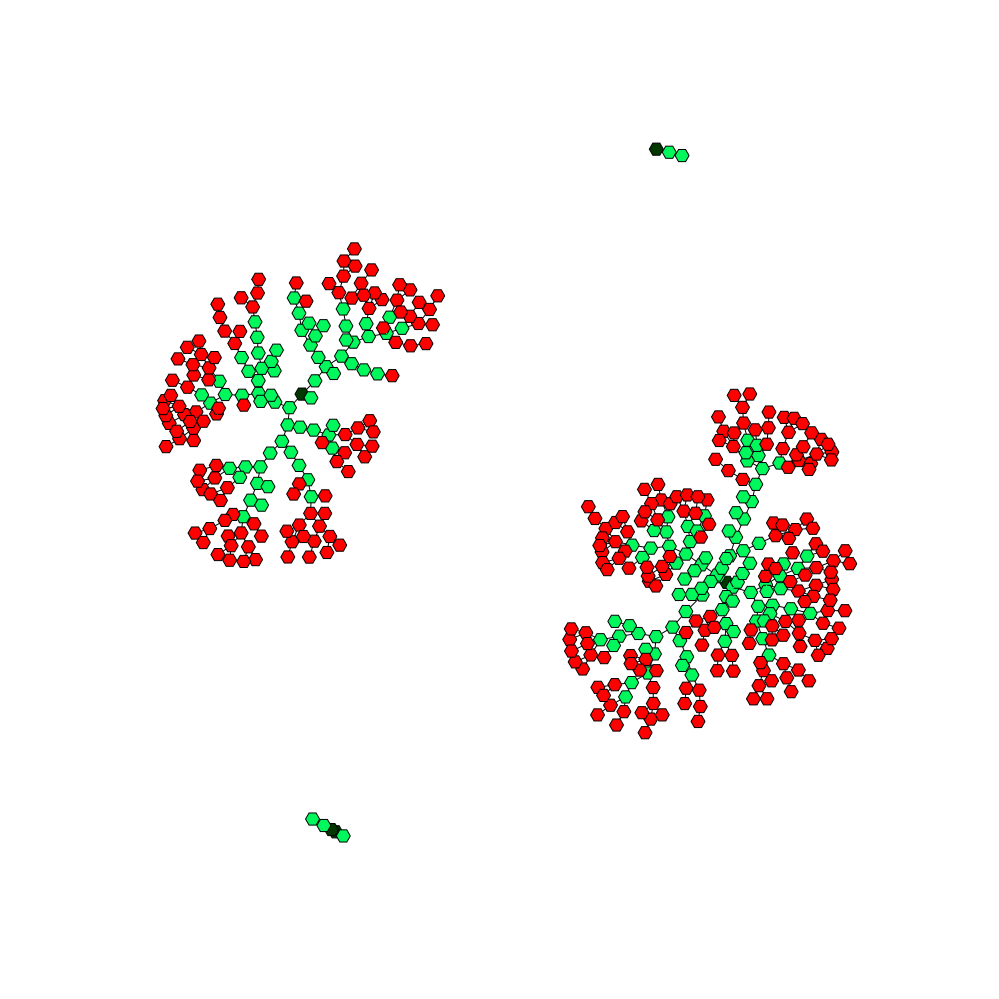

In [39]:
c=distinguishable_colors(3,colorant"red")
colors = [c[estado[v]] for v in vertices(g)]
colors[1:n0] .= c[3]

default(size=(1000,1000))
plot(g,curves=false,nodecolor=colors)